## Introduction ##

The telecom operator, Interconnect, would like to forecast churn of their clients.

**Problem Statement**: The company wants to forecast which users are planning to leave  
**Business Value**: To ensure loyalty, those who are going to leave will be offered with promotional codes and special plan options

Interconnect mainly provides two types of services:
1. Landline communication - the telephone can be connected to several lines simultaneously.
2. Internet - the network can be set up via a telephone line (*DSL*) or through a fiber optic cable. 

Other services the company provides include:
- Internet security via antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. The data is contained in the following files:
- *contract.csv:* contract information
- *personal.csv:* the client's personal data
- *internet.csv:* information about Internet services
- *phone.csv:* information about telephone services

In each file, the *customerId* column contains a unique code assigned to each client. The clients can choose either a monthly payment, or sign a 1 or 2-year contract. They can use various payment methods and receive an electronic invoice after the transaction. The contract information is valid as of February 1, 2020. 

Our goal is to develop a model that will classify the customers into two groups; loyal customers that will stay with Interconnect, and customers that will churn. The target is the *EndDate* column. Values with a date signifies the date the customer left, whereas a "No" means the client is active. The final model quality will be based on its AUC-ROC score ($\ge$ 0.88) and/or accuracy.

## Initialization ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

**Load Data**

Based on our EDA and proposed workflow, we'll convert some of the datatypes and columns values to faciliate merging the datasets, feature encoding, and target variable prediction. Additionally, for clients who have not established a transaction history (i.e. *TotalCharges* values of an empty String) we'll replace those values with 0.0.

In [2]:
# When cloning this project, ensure directory/file paths are correct with respect to user's operating system
contract_df = pd.read_csv('datasets/final_provider/contract.csv', converters={'BeginDate': lambda x: pd.to_datetime(x,  format='%Y-%m-%d'),
                                                                              'TotalCharges': lambda x: 0.0 if x.isspace() else float(x)})
internet_df = pd.read_csv('datasets/final_provider/internet.csv')
personal_df = pd.read_csv('datasets/final_provider/personal.csv')
phone_df = pd.read_csv('datasets/final_provider/phone.csv')

In [3]:
contract_df.info()
internet_df.info()
personal_df.info()
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null 

## Data Preprocessing ##

**Merging the Data**

From our EDA, we discovered customers had an internet subscription, phone subscription, or both. To ensure we do not lose any information, we'll perform a full outer merge on the common column, *customerID*. This will generate NaN values (for customers that did not have both phone and internet subscriptions) that we will replace with appropriate values later on.

In [4]:
df_merged = contract_df.merge(internet_df, on='customerID', how='outer')
df_merged = df_merged.merge(personal_df, on ='customerID', how='outer')
df_merged = df_merged.merge(phone_df, on='customerID', how='outer')

df_merged.info()
display(df_merged.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
6709,7103-IPXPJ,2015-12-01,No,One year,No,Electronic check,99.40,5059.75,Fiber optic,No,No,No,Yes,Yes,Yes,Male,0,Yes,No,Yes
3224,4013-UBXWQ,2019-04-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,74.65,521.10,DSL,No,No,No,Yes,Yes,Yes,Female,0,No,No,Yes
4904,0114-PEGZZ,2017-05-01,No,Month-to-month,No,Electronic check,107.55,3645.50,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,No,No,Yes
4208,9955-QOPOY,2014-05-01,No,One year,Yes,Credit card (automatic),60.80,4263.40,DSL,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,No,NaN
1753,2057-BOYKM,2014-02-01,No,Two year,Yes,Bank transfer (automatic),96.60,6827.50,Fiber optic,Yes,Yes,Yes,Yes,No,No,Female,1,Yes,No,Yes
3135,4803-AXVYP,2016-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.55,3734.25,Fiber optic,No,No,No,Yes,Yes,Yes,Female,1,No,No,Yes
3232,2703-AMTUL,2017-02-01,No,One year,No,Mailed check,53.65,1939.35,DSL,Yes,Yes,No,No,No,No,Male,0,Yes,Yes,No
2285,4307-KTUMW,2015-05-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,93.90,5029.20,Fiber optic,Yes,No,Yes,No,No,Yes,Male,0,Yes,No,Yes
3851,0206-OYVOC,2016-04-01,No,Two year,Yes,Mailed check,19.25,864.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
3475,8610-ZIKJJ,2019-12-01,No,One year,No,Mailed check,20.30,31.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No


**Replacing NaN Values**

We will replace the empty values with either "None" or "No". For the columns *InternetService* and *MultipleLines*, we will replace NaN values with "None", while the columns with NaN in each specific internet service addition will be replaced with "No". This allows us to distinguish customers how had different combinations of subscription packages when we encode our features without losing fidelity on the charactization of the observation.

In [5]:
service_columns = ['InternetService', 'MultipleLines']
internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_merged[service_columns] = df_merged[service_columns].replace(np.NaN, 'None')
df_merged[internet_columns] = df_merged[internet_columns].replace(np.NaN, 'No')

display(df_merged.sample(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
943,6115-ZTBFQ,2014-02-01,No,Two year,No,Bank transfer (automatic),65.50,4919.70,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,No,None
3511,3785-KTYSH,2015-09-01,No,Two year,No,Mailed check,24.60,1279.00,None,No,No,No,No,No,No,Male,0,No,No,Yes
4585,1069-XAIEM,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.05,85.05,Fiber optic,No,No,No,No,No,Yes,Female,1,No,No,Yes
1677,3283-WCWXT,2019-08-01,No,Two year,No,Mailed check,25.40,153.30,None,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
4706,6595-COKXZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,44.45,44.45,DSL,No,No,No,No,No,No,Female,0,No,No,No
2988,6295-OSINB,2014-02-01,No,Two year,Yes,Electronic check,109.65,7880.25,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Male,0,Yes,No,Yes
2708,8510-AWCXC,2018-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,100.80,1308.10,Fiber optic,Yes,No,No,No,Yes,Yes,Female,1,No,No,Yes
1923,7696-CFTAT,2017-01-01,No,Two year,No,Bank transfer (automatic),19.80,726.10,None,No,No,No,No,No,No,Male,0,Yes,Yes,No
3290,7075-BNDVQ,2019-10-01,No,Month-to-month,No,Mailed check,35.00,135.75,DSL,Yes,No,Yes,No,No,No,Female,0,No,No,None
3395,6794-HKIAJ,2014-12-01,No,Month-to-month,No,Bank transfer (automatic),90.70,5586.45,Fiber optic,Yes,Yes,Yes,No,No,No,Male,0,No,No,Yes


**Converting Object to Category**
 
We will convert the object datatypes to category to facilitate models that can handle categorical columns natively (i.e. LightGBM without OHE).

In [6]:
obj_feat = list(df_merged.loc[:, df_merged.dtypes == 'object'].columns.values)

for feat in obj_feat:
    df_merged[feat] = pd.Series(df_merged[feat], dtype="category")

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   category      
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   category      
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   category      
 9   OnlineSecurity    7043 non-null   category      
 10  OnlineBackup      7043 non-null   category      
 11  DeviceProtection  7043 non-null   category      
 12  TechSupport       7043 non-null   category      
 13  StreamingTV       7043 non-null   category      
 14  StreamingMovies   7043 n

## Feature Engineering ##

We'll create a new feature, *ContractLength*, that will contain the number of days a customer had been with Interconnect. Since the data is current up to 2020-02-01, we can view a "snapshot" in time that distinguishes active/new customers from churned customers based on the difference in *EndDate* and *BeginDate*. 

Before we create the new feature, however, we'll preserve the target variable into a new column (named *Churned*) and convert it to a datatype better suited for a binary classification task.

In [7]:
df_merged['Churned'] = df_merged['EndDate'].apply(lambda x: 1 if x != 'No' else 0)
display(df_merged.sample(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned
6995,7164-BPTUT,2015-05-01,No,Two year,No,Mailed check,89.55,5012.35,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,0,No,Yes,Yes,0
7014,9053-EJUNL,2016-09-01,No,Month-to-month,Yes,Electronic check,89.20,3645.75,Fiber optic,No,...,No,No,Yes,No,Male,0,No,No,Yes,0
4385,1930-BZLHI,2018-05-01,No,One year,Yes,Mailed check,20.35,422.70,None,No,...,No,No,No,No,Male,0,No,No,No,0
5032,5429-LWCMV,2019-02-01,No,Month-to-month,Yes,Electronic check,89.15,1057.55,Fiber optic,No,...,No,No,No,Yes,Female,0,No,No,Yes,0
4128,4628-CTTLA,2015-01-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,39.30,2111.45,DSL,No,...,No,No,Yes,No,Male,0,No,No,None,1
5925,1840-BIUOG,2018-06-01,No,One year,Yes,Electronic check,68.70,1416.20,DSL,No,...,No,Yes,Yes,No,Male,0,No,No,Yes,0
3705,9220-CXRSC,2014-05-01,No,Two year,No,Credit card (automatic),61.40,4059.85,DSL,Yes,...,No,Yes,No,No,Female,0,Yes,Yes,Yes,0
4983,1862-SKORY,2016-08-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.30,1637.40,DSL,No,...,No,No,Yes,No,Female,1,Yes,No,None,1
4173,7858-GTZSP,2019-02-01,No,Month-to-month,Yes,Electronic check,86.55,1066.90,Fiber optic,No,...,No,No,No,Yes,Female,0,No,No,Yes,0
4409,5227-JSCFE,2014-03-01,No,Two year,No,Credit card (automatic),46.35,3353.40,DSL,Yes,...,Yes,Yes,No,No,Male,1,Yes,No,None,0


To track contract length, we'll convert EndDate to datetime. If *EndDate* is "No", *EndDate* will be set to the end of the data range (i.e. 2020-02-01). Once the feature is created, we can drop *EndDate* since the target variable was preserved in the previous step.

In [8]:
df_merged['EndDate'] = (df_merged['EndDate'].apply(lambda x: pd.to_datetime('2020-02-01', format='%Y-%m-%d') if x == 'No' else pd.to_datetime(x,  format='%Y-%m-%d'))).astype('datetime64[ns]')
df_merged['ContractLength'] = (df_merged['EndDate'] - df_merged['BeginDate']).dt.days.astype('int64')
df_merged.drop('EndDate', axis=1, inplace=True)

df_merged.info()
df_merged.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   category      
 1   BeginDate         7043 non-null   datetime64[ns]
 2   Type              7043 non-null   category      
 3   PaperlessBilling  7043 non-null   category      
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   7043 non-null   category      
 8   OnlineSecurity    7043 non-null   category      
 9   OnlineBackup      7043 non-null   category      
 10  DeviceProtection  7043 non-null   category      
 11  TechSupport       7043 non-null   category      
 12  StreamingTV       7043 non-null   category      
 13  StreamingMovies   7043 non-null   category      
 14  gender            7043 n

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned,ContractLength
821,5318-YKDPV,2016-07-01,Two year,Yes,Credit card (automatic),79.15,3566.60,DSL,Yes,No,...,Yes,Yes,Yes,Male,0,Yes,Yes,No,0,1310
2272,8064-RAVOH,2020-01-01,Month-to-month,Yes,Electronic check,49.85,49.85,DSL,No,No,...,No,No,No,Male,0,No,Yes,No,0,31
5318,2498-XLDZR,2017-06-01,Two year,No,Mailed check,73.60,2316.85,DSL,Yes,Yes,...,Yes,No,Yes,Female,0,Yes,Yes,No,0,975
3119,5307-DZCVC,2017-03-01,Month-to-month,Yes,Credit card (automatic),85.95,2628.60,Fiber optic,No,No,...,No,Yes,No,Female,1,Yes,No,Yes,1,975
3934,1729-VLAZJ,2019-04-01,One year,No,Mailed check,40.25,411.45,DSL,Yes,Yes,...,Yes,No,No,Female,0,No,Yes,None,0,306
307,4115-BNPJY,2017-09-01,Two year,No,Mailed check,75.55,2054.40,DSL,No,No,...,Yes,Yes,Yes,Male,0,Yes,Yes,No,0,883
3937,5712-VBOXD,2019-10-01,Month-to-month,Yes,Credit card (automatic),20.15,68.45,None,No,No,...,No,No,No,Female,0,No,No,No,0,123
4603,3594-KADLU,2019-11-01,Month-to-month,No,Mailed check,35.10,101.10,DSL,Yes,No,...,Yes,No,No,Male,0,Yes,No,None,0,92
1231,0384-RVBPI,2018-06-01,Month-to-month,No,Credit card (automatic),64.40,1398.60,DSL,Yes,No,...,No,No,Yes,Male,0,No,No,No,0,610
3387,3530-CRZSB,2019-07-01,Month-to-month,No,Mailed check,20.65,155.90,None,No,No,...,No,No,No,Female,0,No,No,No,0,215


## Feature Selection ##

We've already identified the target variable (*Churned*), but we will exclude administrative features such as *BeginDate* and *customerID* from training. Additionally, we'll encode the features (OHE) for training certain models.

In [9]:
drop_list = ['customerID', 'BeginDate', 'Churned']

features = df_merged.drop(drop_list, axis=1)
features_ohe = pd.get_dummies(features, drop_first=True)
target = df_merged['Churned']

**Splitting the Data**

We'll split the processed dataset into training and validation sets using a 3:1 ratio.

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(features_ohe, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(5282, 23)
(5282,)
(1761, 23)
(1761,)


**Class Imbalance**

Before we train our non-gradient boosting models, we will examine whether a class imbalance exists in the training set.

In [11]:
print('Number of positive classes: ', (target_train == 1).sum())
print('Number of negative classes: ', (target_train == 0).sum())

Number of positive classes:  1395
Number of negative classes:  3887


There is about a 1:3 positive to negative class imbalance. We'll address these during our evaluation by adding a transformer in the pipeline.

## Model Training ##

AUC-ROC is a suitable metric for this task, but using accuracy as a secondary metric may not be that helpful as it does not provide insight to a model's precision and/or recall. A more suitable secondary metric may be F1 score, and thus will be incorporated in the evaluations (in addition to AUC-ROC and accuracy).

We'll define the function, *train_and_evaluate( )*, which will train and cross-validate each model via grid search of different hyperparameter combinations. Each fold of the training set will be scaled using *MaxAbsScaler( )* and balanced using SMOTE. The best estimator from each grid search will then be evaluated against the validation set. Lastly, the function will calculate and plot the evaluation metrics:

**Parameters:**  
*model:* Model to be trained and evaluated  
*feat_train:* array-like containing the training features  
*tgt_train:* array-like containing the training target values  
*feat_val:* array-like containing the validation features on which the model will make predictions  
*tgt_val:* array-like containing the true target values for the validation set  
*name:* string object of the model name (for print/display purposes only)  
*params:* dictionary containing the model hyperparameters that will be permuted duing the grid search, empty by default  

**Returns**: Nothing. Prints the best estimator's parameter combination, calculates the model's mean CV score, validation set AUC-ROC, F1, and accuracy scores. Additionally, plots the ROC curve.

In [12]:
def train_and_evaluate(model, feat_train, tgt_train, feat_val, tgt_val, name, params={}):

    ct = ColumnTransformer([('scaler', MaxAbsScaler(), ['MonthlyCharges', 'TotalCharges', 'ContractLength'])], remainder='passthrough')
    smt = SMOTE(random_state=12345)
    pipe = Pipeline([('col_transform' , ct), ('smt', smt), ('model', model)])
    
    grid_pipeline = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid_pipeline.fit(feat_train, tgt_train)
    
    estimator = grid_pipeline.best_estimator_
    probabilities = estimator.predict_proba(feat_val)
    probabilities_one_test = probabilities[:, 1]

    print(f'{name}: \n')
    print('Best parameters: ', grid_pipeline.best_params_)
    print('Best mean cv score: ', grid_pipeline.best_score_)  
    print('Validation AUC-ROC score: ', roc_auc_score(tgt_val, probabilities_one_test))
    print('Validation F1 score: ', f1_score(tgt_val, estimator.predict(feat_val)))
    print('Validation accuracy score: ', accuracy_score(tgt_val, estimator.predict(feat_val)))
    
    RocCurveDisplay.from_predictions(tgt_val, probabilities_one_test, name=name, color="darkorange")
    plt.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return

**Dummy Classifier**

As a baseline, we'll train a dummy classifier to uniformly predict the target variable (i.e. equal bias to postive and negative class).

Uniform Classifier: 

Best parameters:  {}
Best mean cv score:  0.5
Validation AUC-ROC score:  0.5
Validation F1 score:  0.37390029325513197
Validation accuracy score:  0.5150482680295286


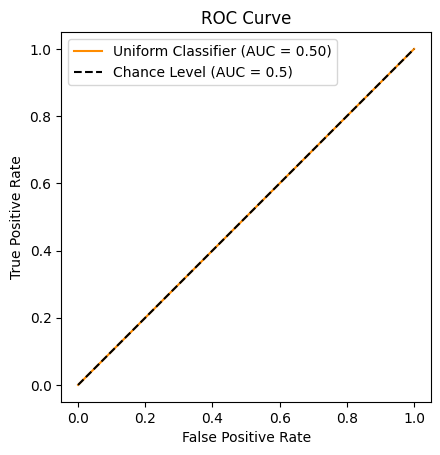

In [13]:
train_and_evaluate(DummyClassifier(strategy='uniform', random_state=12345), 
                   features_train,
                   target_train,
                   features_valid, 
                   target_valid,
                   'Uniform Classifier')

**Logistic Regression**

Linear models such as logistic regression basically lack hyperparameter tuning, but we'll conduct a grid search using different solvers and compare results.

Logistic Regression: 

Best parameters:  {'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best mean cv score:  0.8458871349285149
Validation AUC-ROC score:  0.8384887498811551
Validation F1 score:  0.6301824212271975
Validation accuracy score:  0.7467348097671778


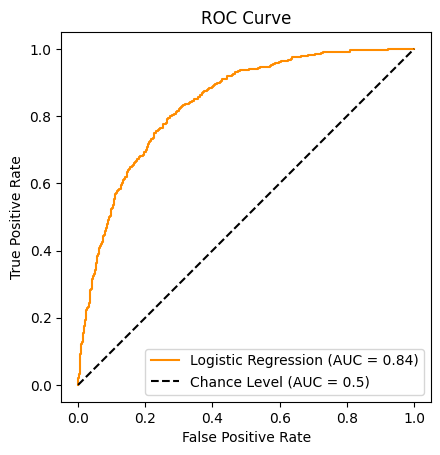

In [14]:
parameters = {'model__penalty': ['l2'],
              'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']}

train_and_evaluate(LogisticRegression(random_state=12345), 
                   features_train,
                   target_train,
                   features_valid, 
                   target_valid, 
                   'Logistic Regression', 
                   parameters)

The best logistic regression model had an avgerage CV score of 0.85, and validation AUC-ROC score of 0.84. The F1 score is 0.63 while the accuracy 0.75, indicating there may be a few churned customers not being accounted for.

**Decision Tree Classifier**

For the decision tree classifier, we'll tune *max_depth*, *min_samples_split*, *min_samples_leaf*, and *max_features*.

Decision Tree Classifier: 

Best parameters:  {'model__max_depth': 6, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4}
Best mean cv score:  0.8318833066656269
Validation AUC-ROC score:  0.8459235326323934
Validation F1 score:  0.6300366300366301
Validation accuracy score:  0.7705848949460534


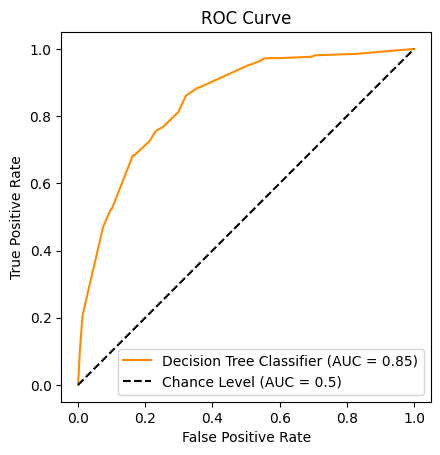

In [15]:
parameters = {'model__max_depth': list(range(3, 30)),
              'model__min_samples_split': [2, 4, 6],
              'model__min_samples_leaf': [0.1, 0.5, 1, 5, 10],
              'model__max_features': [None, 'sqrt', 'log2']}

train_and_evaluate(DecisionTreeClassifier(random_state=12345), 
                   features_train,
                   target_train,
                   features_valid, 
                   target_valid, 
                   'Decision Tree Classifier', 
                   parameters)

Our best decision tree had a mean CV score of 0.83, but appears to be overfit with a validation AUC-ROC score of 0.85. Again, the F1 score (0.63) is lower than its accuracy (0.77) likely due to more false negatives or false positives being predicted.

**Random Forest Classifier**

Based off the decision tree results, we'll only tune the random forest classifier's *n_estimators*, *max_depth*, and *max_features* for the sake of runtime.

Random Forest Classifier: 

Best parameters:  {'model__max_depth': 20, 'model__max_features': None, 'model__n_estimators': 100}
Best mean cv score:  0.8528476037432003
Validation AUC-ROC score:  0.856875309406955
Validation F1 score:  0.6460268317853457
Validation accuracy score:  0.8052243043725156


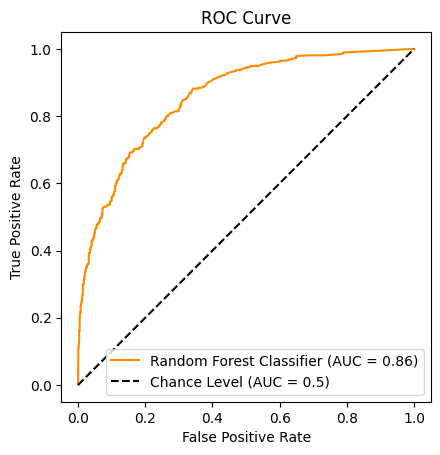

In [16]:
parameters = {'model__n_estimators': [100, 200, 300],
              'model__max_depth': list(range(18, 26)),
              'model__max_features': [None, 'sqrt', 'log2']}

train_and_evaluate(RandomForestClassifier(random_state=12345), 
                   features_train,
                   target_train,
                   features_valid, 
                   target_valid, 
                   'Random Forest Classifier', 
                   parameters)

The random forest classifier also exhibits moderate overfitting. The mean CV score was 0.85, but the validation AUC-ROC score was 0.86. The F1 and accuracy scores on the validation set were 0.65 and 0.80, respectively.

## Gradient Boosting Models ##

The next two models we'll train will be gradient boosting models (LightGBM and CatBoost). These models should be able to handle the class imbalance without the need of over/under sampling, but we'll keep the SMOTE transformation in the pipeline. Additionally, since we're applying a sequence of transformations to our training sets during each fold, our models can't take advantage of their native ability to address categorical features (without additional steps) and thus the features will be left as encoded.

**LightGBM Classifier**

The hyperparameters we'll tune for the LightGBM classifier will be its *boosting type*, *learning_rate*, and *n_estimators*.

LightGBM Classifier: 

Best parameters:  {'model__boosting_type': 'gbdt', 'model__learning_rate': 0.06, 'model__n_estimators': 500}
Best mean cv score:  0.8943902267685335
Validation AUC-ROC score:  0.8989071172615476
Validation F1 score:  0.720879120879121
Validation accuracy score:  0.855763770584895


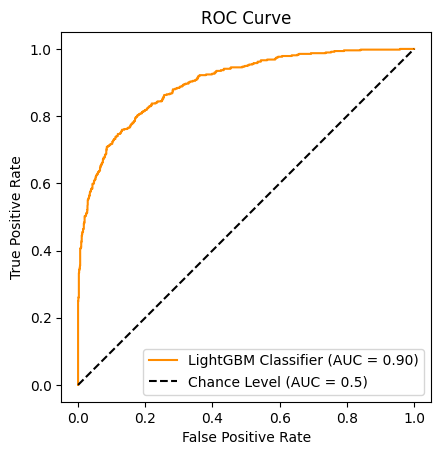

In [17]:
parameters = {'model__boosting_type': ['dart', 'gbdt'],
              'model__learning_rate': [0.03, 0.06, 0.09, 0.1],
              'model__n_estimators': [100, 300, 500]}

train_and_evaluate(LGBMClassifier(random_state=12345), 
                   features_train, 
                   target_train,
                   features_valid,
                   target_valid,
                   'LightGBM Classifier', 
                   parameters)

The LightGBM classifier had more consistent results between the training and validation sets, with an average CV score and validation AUC-ROC score just under 0.90. The F1 and accuracy scores were also higher than the previous models, reaching 0.72 and 0.86, respectively.

**CatBoost Classifier**

For the CatBoost classifier, we'll explicitly pass the column names of the categorical features and tune the *learning_rate*, *depth*, and *iterations* hyperparameters.

CatBoost Classifier: 

Best parameters:  {'model__depth': 4, 'model__iterations': 500, 'model__learning_rate': 0.1}
Best mean cv score:  0.906184828520843
Validation AUC-ROC score:  0.9092736845901402
Validation F1 score:  0.7342888643880926
Validation accuracy score:  0.8631459398069279


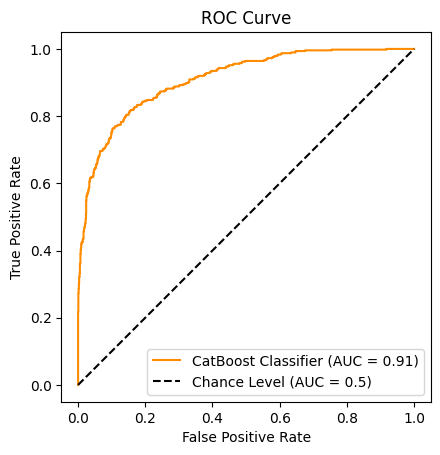

In [18]:
parameters = {'model__learning_rate': [0.1, 0.6, 0.9, 0.99],
              'model__depth' : [4, 6, 8, 10],
              'model__iterations' : [100, 300, 500]}

train_and_evaluate(CatBoostClassifier(random_state=12345, verbose=False), 
                   features_train, 
                   target_train,
                   features_valid,
                   target_valid,
                   'CatBoost Classifier', 
                   parameters)

Our best CatBoost classifier had a mean CV score and final AUC-ROC score of 0.91. Its F1 score still lags behind accuracy, achieving scores 0.73 and 0.86, respectively.

## Conclusion ##

Based on the evaluation results, our best performing model was the CatBoost classifier. When tuning the learning rate, depth, and number of iterations, the model was able to surpass our goal of 0.88 with a final AUC-ROC of 0.91. Additionally, the model achieved the highest ancillary performance metrics with an F1 score of 0.73 and accuracy score of 0.86. This project demonstrated the strength of gradient boosting models (compared to "legacy" models) in classification tasks where the dataset was almost entirely made up of categorical features and exhibited a class imbalance. While the final model had an acceptable performance, there is still information to be gleaned from the different F1 scores.

All of the models consistently had lower F1 scores when compared to their accuracy. This indicates a deficiency in precision and/or recall; in short, our models exhibit signs of predicting more false negatives or false positives than impliced by the accuracy metric. Practically speaking, generating more false positives may not impact Interconnect's objective to forecast customer churn rate; that is, loyal customers will likely stay whether or not they were offered a subscription incentive. But if Interconnect's product promotions does not appear to lower churn rate, this may be an indication that our model needs a better solution or more data for handling false negatives.